In [ ]:
#%% Import packages and load data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#%% load preprocessed data

df = pd.read_csv('../Dataset/processed_data_socmot.csv')
# This final data has been through following preprocessing steps: (details see SocMot_EDA.ipynb)
# 1. Extract data with interest:only keep wave2 (pandemic) data (since only wave2 has SWLS)
# 2. Deal with missing values: drop social motives that only apply to a small subset of the sample (KCC, MRT, MRB) then impute missing values
# 3. Coarse-grain: merge country into continent 
# 4. Imbalance categories: filter out categories with extremely few records (Oceania in Continent, Other in Gender, Divorced/Widowed in Relationship) then up-sample to make categories more balanced

In [ ]:
#%% Claim variables

# detailed description of variables and preprocess can be found in SocMot_EDA.ipynb

#target variable
target='swls'
#Satisfaction with life composite

#numerical variables
abandoned_motives = ['KCC','MRT','MRB']
social_motives = [x for x in ['SPO','DIS', 'AFG','AFI','AFX','STA','MAT','KCF'] if x not in abandoned_motives]
#Self-protection (SPO), Disease Avoidance (DIS), Affiliation (Group) (AFG), Affiliation (Independence) (AFI), Affiliation (Exclusion Concern) (AFX), Status (STA), Mate Seeking (MAT), Breakup Concern (MRB), Mate Retention (MRT), Kin Care (Family) (KCF), Kin Care (Children) (KCC).
#MRB, MRT, KCC are abandoned, as they only apply to a small subset of the sample

learn_social_motives = [f'learn{sm}' for sm in social_motives]

not_motives_numerical_vars=['SubjSES', 'Age', 'Children', 'Food', 'Water', 'Sleep', 'Temperature', 'Safe']

numerical_vars = not_motives_numerical_vars + social_motives + learn_social_motives


# Ensure all numerical variables and target are numeric
df[numerical_vars] = df[numerical_vars].apply(pd.to_numeric, errors='coerce')
df[target] = df[target].apply(pd.to_numeric, errors='coerce')


#categorical variables
categorical_vars=["Gender", "Relationship","Continent"]
# Note Country and Continent are related, I only use Continent instead of Country for coarse-grained robustness

In [ ]:
# %% 

# Preprocessing features
X_num = df[numerical_vars]
X_cat = df[categorical_vars]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out())


X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
y = df[target]

print("Features shape:", X.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

Features shape: (25444, 35)

First few rows of features:
    SubjSES       Age  Children      Food     Water     Sleep  Temperature  \
0  0.518563  1.015007  1.596687  0.576781  0.478283  0.503310     0.596165   
1  0.518563 -0.857681 -0.515296  0.576781  0.478283  0.503310     0.596165   
2 -1.125180 -0.613418 -0.515296  0.576781  0.478283  0.503310     0.596165   
3 -1.673094  3.294802 -0.515296  0.576781  0.478283  0.503310     0.596165   
4 -0.029351 -0.613418 -0.515296 -2.149636 -0.314669 -0.290284    -0.880622   

       Safe       SPO       DIS  ...  Gender_Male  \
0  0.805648  1.191263  0.463040  ...          0.0   
1  0.805648 -1.330556 -1.210743  ...          1.0   
2  0.805648 -0.645279  0.544030  ...          1.0   
3  0.805648 -2.289943 -1.750673  ...          1.0   
4 -0.557311  0.697864 -0.400848  ...          1.0   

   Relationship_Committed Relationship  Relationship_Dating  \
0                                  0.0                  0.0   
1                            

In [ ]:
#%%

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=133)

In [ ]:
#%%

def train_evaluate(model, X_train, X_test, y_train, y_test, params="default"):
    """
    Train model with given parameters and evaluate performance
    
    Args:
        model: sklearn model object
        X_train, X_test, y_train, y_test: train/test data splits
        params: dictionary of model parameters (optional)
        
    Returns:
        Dictionary containing model parameters and evaluation metrics
    """
    from sklearn.metrics import r2_score, mean_squared_error
    
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    metrics = {
        'performance': {
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred))
        }
    }
    
    # Get feature importance for linear models and tree models
    if hasattr(model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        metrics['feature_importance'] = feature_importance
    elif hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        metrics['feature_importance'] = feature_importance
    
    # Print results
    print(f"\n{type(model).__name__} Results:")
    print(f"Model parameters: {params}")
    print(f"Train R2: {metrics['performance']['train_r2']:.3f}")
    print(f"Test R2: {metrics['performance']['test_r2']:.3f}") 
    print(f"Train RMSE: {metrics['performance']['train_rmse']:.3f}")
    print(f"Test RMSE: {metrics['performance']['test_rmse']:.3f}")
    
    if 'feature_importance' in metrics:
        print("\nFeature Importance:")
        print(metrics['feature_importance'])
        
    return metrics

In [ ]:
#%% Model Exploration 

# train different models and compare performance
performance_metrics = {}

# Note: for those numerical parameters, I tried some different ranges and found that the effect was relatively salient within used interval. Therefore, these values are included in the final model for comparison.

In [ ]:
#%% 

# Linear Model

In [ ]:
#%%

# Basic Regression
from sklearn.linear_model import LinearRegression

for fit_intercept in [True, False]:
    lr_model = LinearRegression(fit_intercept=fit_intercept)
    lr_results = train_evaluate(lr_model, X_train, X_test, y_train, y_test, params=f"fit_intercept={fit_intercept}")
    model_name = f'Linear Regression (intercept={fit_intercept})'
    performance_metrics[model_name] = lr_results['performance']


LinearRegression Results:
Model parameters: fit_intercept=True
Train R2: 0.290
Test R2: 0.288
Train RMSE: 1.157
Test RMSE: 1.155

Feature Importance:
                                Feature  Coefficient
0                               SubjSES     0.433568
28                 Relationship_Married     0.266966
30                     Continent_Africa    -0.225927
29                  Relationship_Single    -0.220465
12                                  AFX    -0.218223
7                                  Safe     0.204976
10                                  AFG     0.183230
1                                   Age    -0.168475
3                                  Food     0.156875
33              Continent_North America     0.117470
27                  Relationship_Dating    -0.114278
32                     Continent_Europe     0.113118
4                                 Water    -0.108221
18                             learnAFG     0.106129
16                             learnSPO    -0.093177
9

In [ ]:
#%%

# Lasso (L1 Regularization) with different parameters
from sklearn.linear_model import Lasso


lasso_alphas = [0.001, 0.01, 0.1, 0.2]
# With intercept, different alphas
for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=True)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Lasso (α={alpha}, intercept=True)'
    performance_metrics[model_name] = lasso_results['performance']

# Without intercept, different alphas
for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=False)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Lasso (α={alpha}, intercept=False)'
    performance_metrics[model_name] = lasso_results['performance']


Lasso Results:
Model parameters: alpha=0.001, fit_intercept=True
Train R2: 0.290
Test R2: 0.288
Train RMSE: 1.157
Test RMSE: 1.155

Feature Importance:
                                Feature   Coefficient
0                               SubjSES  4.334709e-01
28                 Relationship_Married  2.887389e-01
30                     Continent_Africa -2.235567e-01
12                                  AFX -2.144964e-01
7                                  Safe  2.041131e-01
29                  Relationship_Single -1.852558e-01
10                                  AFG  1.810482e-01
1                                   Age -1.633320e-01
3                                  Food  1.551535e-01
4                                 Water -1.049677e-01
18                             learnAFG  1.028409e-01
26  Relationship_Committed Relationship  9.380575e-02
33              Continent_North America  9.089955e-02
24                        Gender_Female  8.791227e-02
32                     Continent_Euro

In [ ]:
#%%

# Ridge (L2 Regularization) with different parameters
from sklearn.linear_model import Ridge

ridge_alphas = [10,50, 1000, 2000]
# With intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Ridge (α={alpha}, intercept=True)'
    performance_metrics[model_name] = ridge_results['performance']

# Without intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=False)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Ridge (α={alpha}, intercept=False)'
    performance_metrics[model_name] = ridge_results['performance']


Ridge Results:
Model parameters: alpha=10, fit_intercept=True
Train R2: 0.290
Test R2: 0.288
Train RMSE: 1.157
Test RMSE: 1.155

Feature Importance:
                                Feature  Coefficient
0                               SubjSES     0.433411
28                 Relationship_Married     0.265541
30                     Continent_Africa    -0.223458
29                  Relationship_Single    -0.219616
12                                  AFX    -0.217773
7                                  Safe     0.204844
10                                  AFG     0.182997
1                                   Age    -0.167842
3                                  Food     0.156781
33              Continent_North America     0.116673
27                  Relationship_Dating    -0.113734
32                     Continent_Europe     0.112297
4                                 Water    -0.107903
18                             learnAFG     0.105831
16                             learnSPO    -0.092673
9 

In [ ]:
#%%

# Decision Tree Regressor with different parameters
from sklearn.tree import DecisionTreeRegressor

# Try different max_depths and criterion
# I also tried min_samples_leaf, but it has very little influence on the performance. My guess is that this parameter is intervened by max_depth. So I only keep max_depth in the final model.
dt_max_depths = [2, 5, 10]
dt_criterion = ['squared_error', 'absolute_error']

for max_depth in dt_max_depths:
    for criterion in dt_criterion:
        dt_model = DecisionTreeRegressor(max_depth=max_depth, 
                                       criterion=criterion,
                                       random_state=133)
        dt_results = train_evaluate(dt_model, X_train, X_test, y_train, y_test, 
                                    params=f"max_depth={max_depth}, criterion={criterion}")
        model_name = f'Decision Tree (depth={max_depth}, criterion={criterion})'
        performance_metrics[model_name] = dt_results['performance']


DecisionTreeRegressor Results:
Model parameters: max_depth=2, criterion=squared_error
Train R2: 0.185
Test R2: 0.182
Train RMSE: 1.240
Test RMSE: 1.238

Feature Importance:
                                Feature  Importance
0                               SubjSES    0.851335
7                                  Safe    0.148665
26  Relationship_Committed Relationship    0.000000
20                             learnAFX    0.000000
21                             learnSTA    0.000000
22                             learnMAT    0.000000
23                             learnKCF    0.000000
24                        Gender_Female    0.000000
25                          Gender_Male    0.000000
27                  Relationship_Dating    0.000000
18                             learnAFG    0.000000
28                 Relationship_Married    0.000000
29                  Relationship_Single    0.000000
30                     Continent_Africa    0.000000
31                       Continent_Asia    0.0

In [ ]:
#%% Random Forest Regressor

# Random Forest Regressor with different parameters 
from sklearn.ensemble import RandomForestRegressor

# Try different number of trees, max depths and criterion
# I also tried different number of trees (`n_estimators`), but it has very little influence on the performance. So I choose n_estimators=40 as a balance between performance and speed.
rf_max_depths = [2, 5, 10]
rf_criterion = ['squared_error', 'absolute_error']

for max_depth in rf_max_depths:
    for criterion in rf_criterion:
        rf_model = RandomForestRegressor(max_depth=max_depth, 
                                           criterion=criterion,
                                           n_estimators=40,
                                           random_state=133,n_jobs=-1)
        rf_results = train_evaluate(rf_model, X_train, X_test, y_train, y_test,
                                  params=f"max_depth={max_depth}, criterion={criterion}")
        model_name = f'Random Forest (depth={max_depth}, criterion={criterion})'
        performance_metrics[model_name] = rf_results['performance']


RandomForestRegressor Results:
Model parameters: max_depth=2, criterion=squared_error
Train R2: 0.188
Test R2: 0.186
Train RMSE: 1.238
Test RMSE: 1.235

Feature Importance:
                                Feature  Importance
0                               SubjSES    0.839557
7                                  Safe    0.160443
26  Relationship_Committed Relationship    0.000000
20                             learnAFX    0.000000
21                             learnSTA    0.000000
22                             learnMAT    0.000000
23                             learnKCF    0.000000
24                        Gender_Female    0.000000
25                          Gender_Male    0.000000
27                  Relationship_Dating    0.000000
18                             learnAFG    0.000000
28                 Relationship_Married    0.000000
29                  Relationship_Single    0.000000
30                     Continent_Africa    0.000000
31                       Continent_Asia    0.0


Performance metrics for all models (sorted by test RMSE and test R²):
                                                    train_r2  test_r2  train_rmse  test_rmse
Random Forest (depth=10, criterion=squared_error)     0.7491   0.7084      0.6880     0.7392
Random Forest (depth=10, criterion=absolute_error)    0.7194   0.6815      0.7277     0.7725
Decision Tree (depth=10, criterion=squared_error)     0.6401   0.5949      0.8240     0.8713
Decision Tree (depth=10, criterion=absolute_error)    0.5890   0.5326      0.8806     0.9360
Random Forest (depth=5, criterion=squared_error)      0.3575   0.3481      1.1010     1.1053
Random Forest (depth=5, criterion=absolute_error)     0.3457   0.3337      1.1111     1.1174
Decision Tree (depth=5, criterion=squared_error)      0.3057   0.2982      1.1446     1.1469
Ridge (α=50, intercept=False)                         0.2903   0.2879      1.1572     1.1552
Lasso (α=0.001, intercept=True)                       0.2904   0.2877      1.1571     1.1554

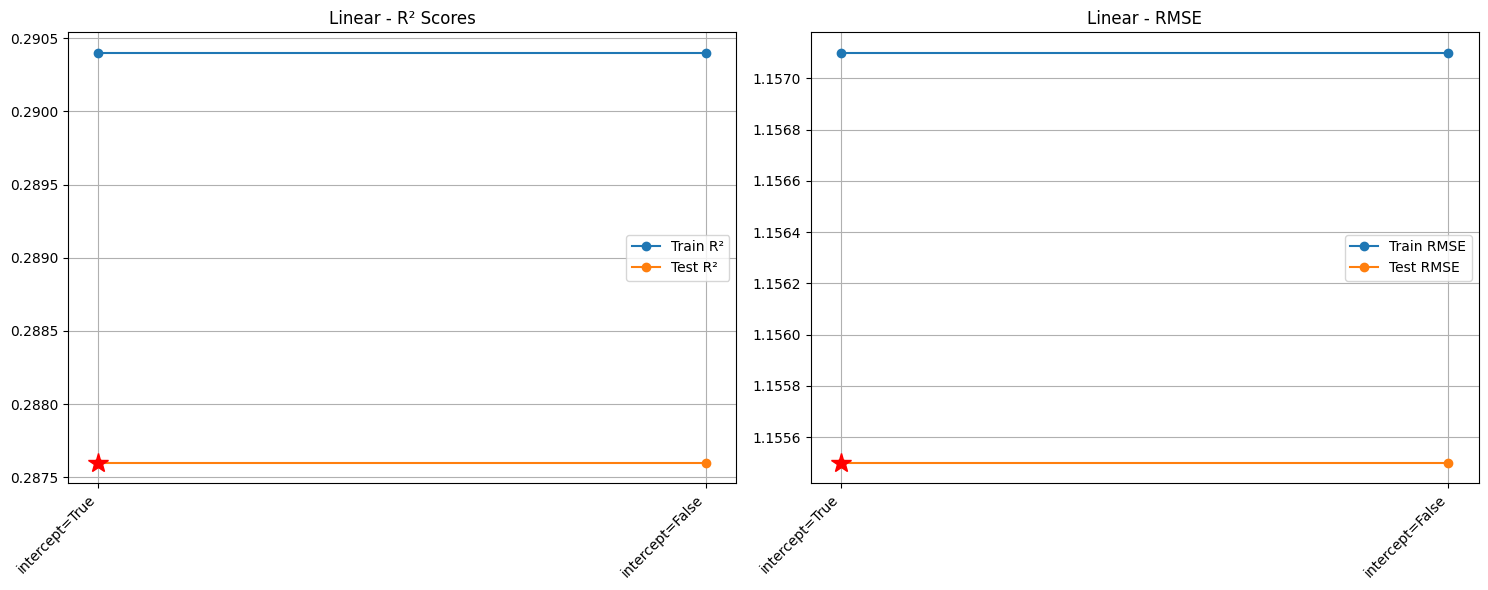

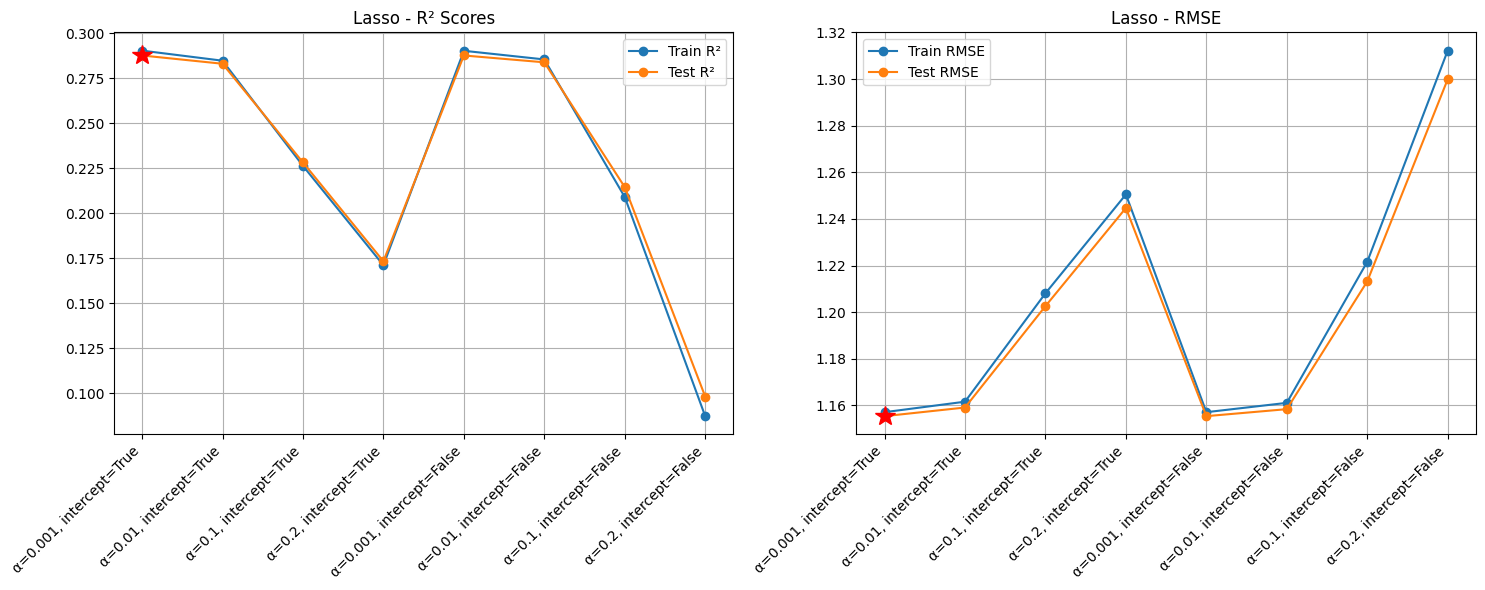

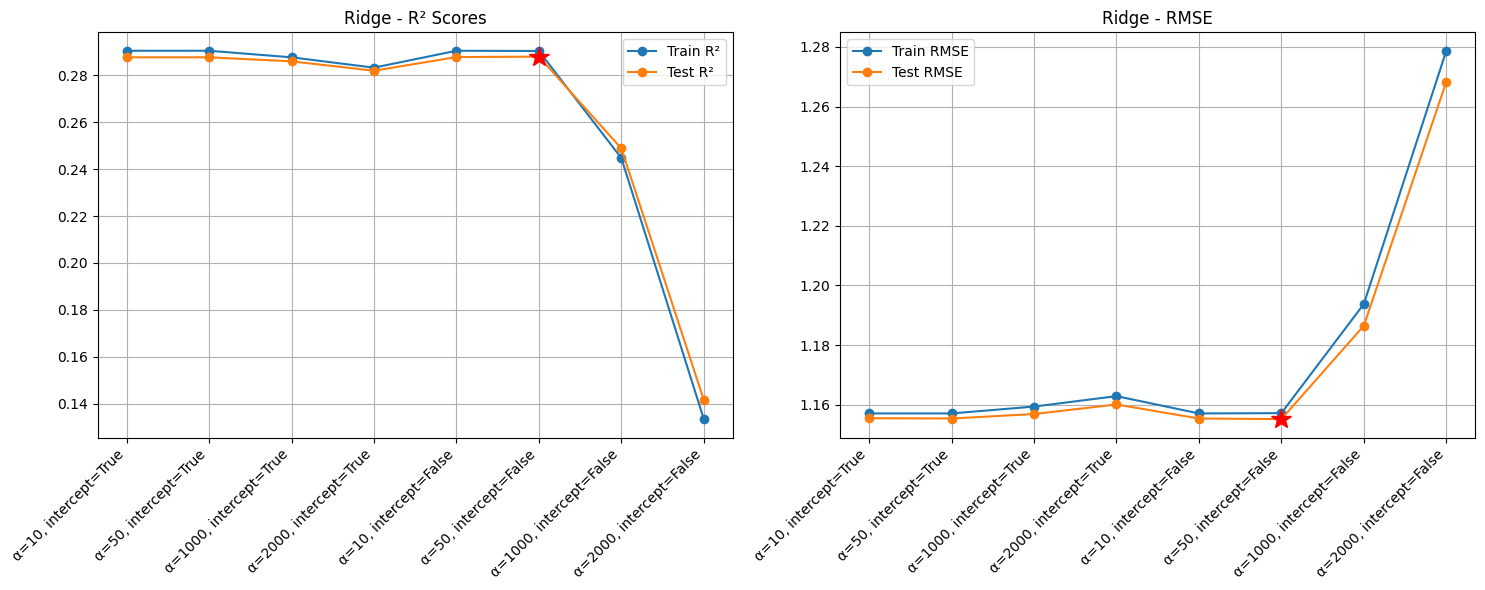

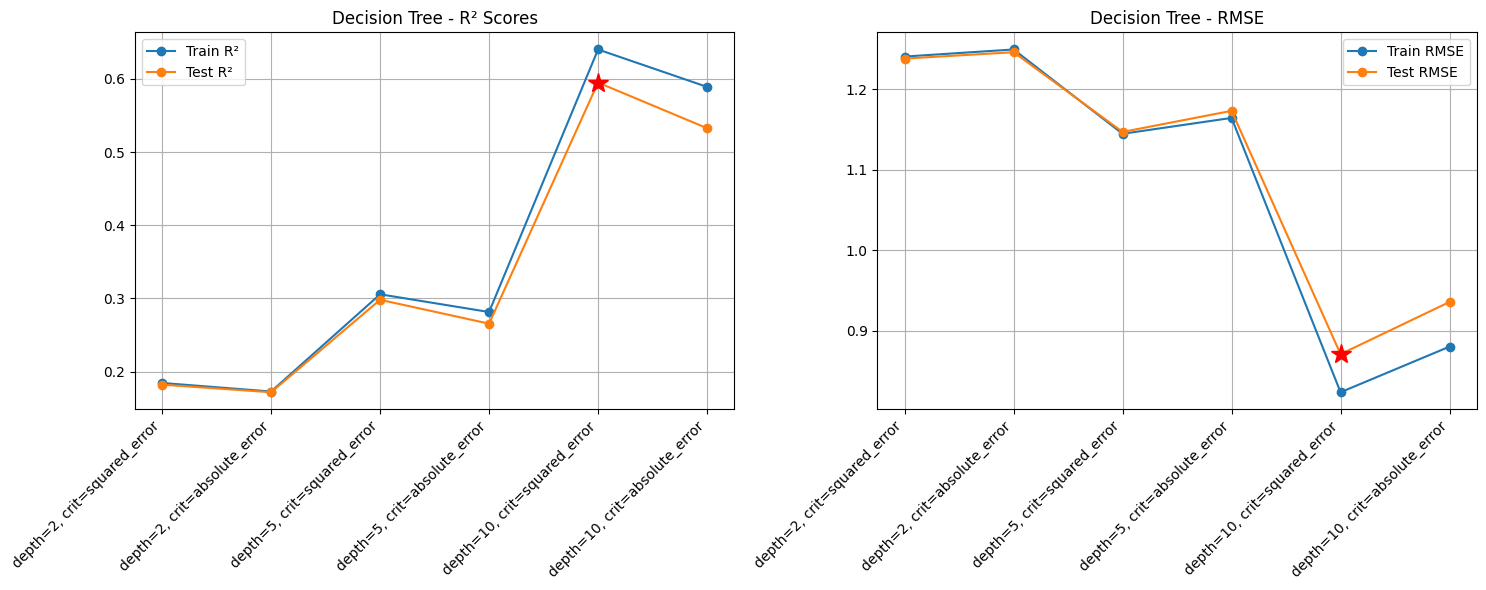

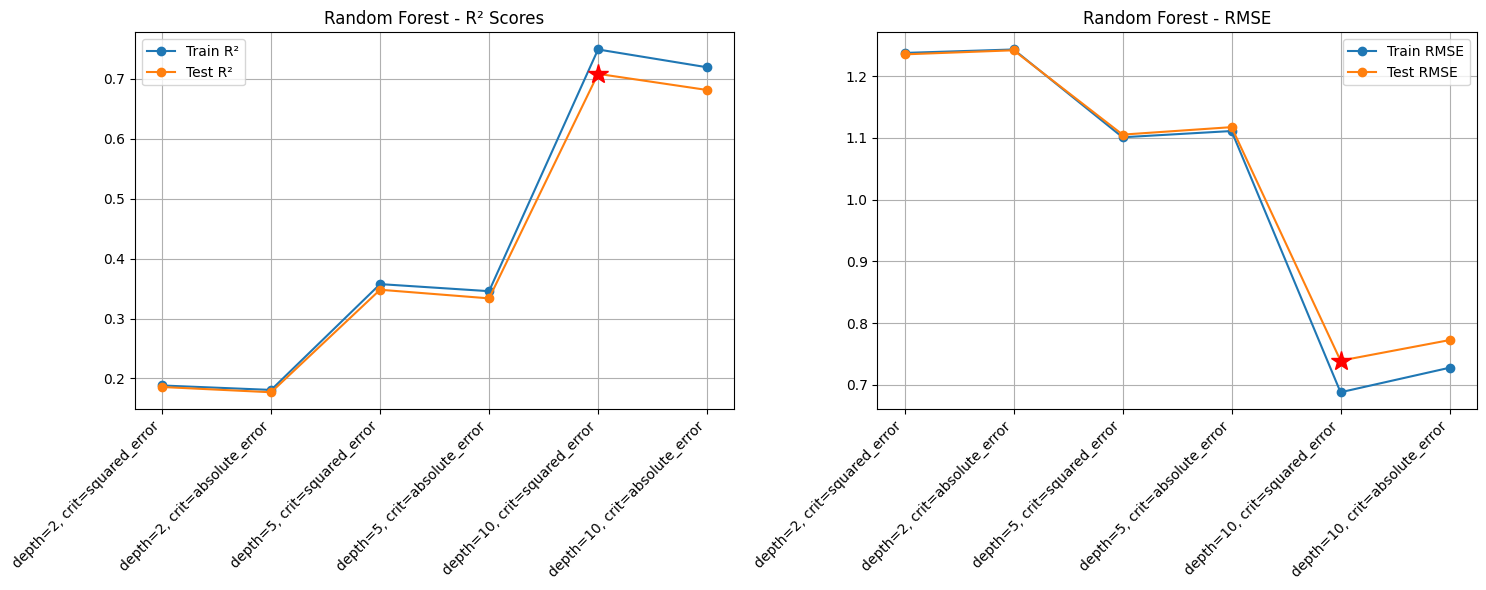

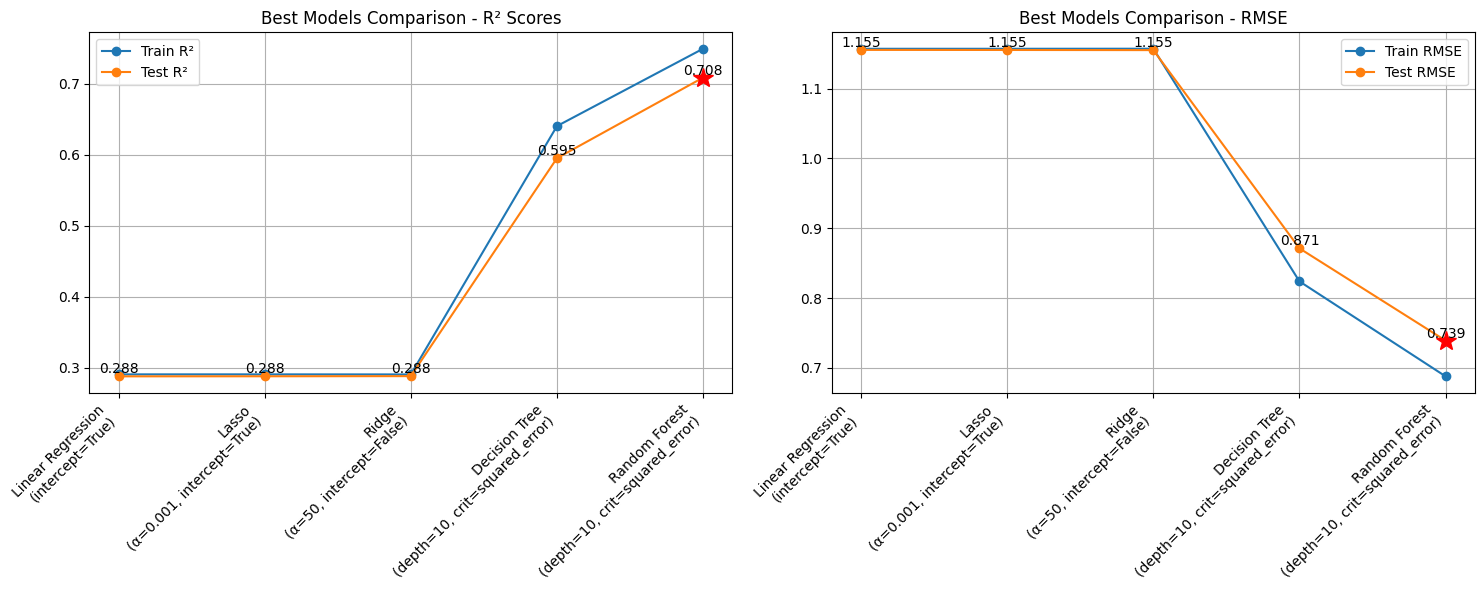

In [ ]:
#%% evaluation

# Evaluation
# Sort and find best model
df_metrics = pd.DataFrame.from_dict(performance_metrics, orient='index')
# Round metrics to 4 decimal places before sorting
df_metrics = df_metrics.round(4)
# Sort by metrics with priority: test_rmse > test_r2 > train_rmse > train_r2
df_metrics_sorted = df_metrics.sort_values(
    ['test_rmse', 'test_r2', 'train_rmse', 'train_r2'], 
    ascending=[True, False, True, False]
)

# Get best model for each type
model_types = {
    'Linear': 'Linear',
    'Lasso': 'Lasso', 
    'Ridge': 'Ridge',
    'Decision Tree': 'Decision Tree',
    'Random Forest': 'Random Forest'
}

best_models = {}
for model_type in model_types.values():
    type_models = df_metrics_sorted[df_metrics_sorted.index.str.startswith(model_type)]
    if not type_models.empty:
        best_models[model_type] = type_models.index[0]

# Print sorted performance metrics
print("\nPerformance metrics for all models (sorted by test RMSE and test R²):")
print("=" * 80)
print(df_metrics_sorted.to_string())

# Visualization functions
def create_model_comparison_plot(df, model_type, ax1, ax2):
    model_data = df[df.index.str.startswith(model_type)]
    if model_data.empty:
        return
    
    # Create shortened labels
    labels = []
    for idx in model_data.index:
        # Extract parameters part
        params = idx.split('(')[1].rstrip(')')
        # Shorten parameter names
        params = params.replace('max_depth', 'md').replace('min_samples_leaf', 'msl') \
                      .replace('criterion', 'crit').replace('n_estimators', 'n_est') \
                      .replace('learning_rate', 'lr').replace('alpha', 'a')
        labels.append(params)
    
    x = range(len(model_data))
    
    # Plot R2
    ax1.plot(x, model_data['train_r2'], label='Train R²', marker='o')
    ax1.plot(x, model_data['test_r2'], label='Test R²', marker='o')
    
    # Add star for best model
    best_idx = model_data['test_rmse'].idxmin()
    best_x = list(model_data.index).index(best_idx)
    ax1.plot(best_x, model_data.loc[best_idx, 'test_r2'], marker='*', color='red', markersize=15)
    
    ax1.set_title(f'{model_type} - R² Scores')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True)
    
    # Plot RMSE
    ax2.plot(x, model_data['train_rmse'], label='Train RMSE', marker='o')
    ax2.plot(x, model_data['test_rmse'], label='Test RMSE', marker='o')
    
    # Add star for best model
    ax2.plot(best_x, model_data.loc[best_idx, 'test_rmse'], marker='*', color='red', markersize=15)
    
    ax2.set_title(f'{model_type} - RMSE')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True)

# Plot each model type separately
for model_type in model_types.values():
    if df_metrics[df_metrics.index.str.startswith(model_type)].empty:
        continue
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    create_model_comparison_plot(df_metrics, model_type, ax1, ax2)
    plt.tight_layout()
    plt.show()

# Plot comparison of best models
best_models_data = df_metrics.loc[list(best_models.values())]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create shortened labels for parameter names
best_labels = []
param_abbreviations = {
    'max_depth': 'md', 
    'min_samples_leaf': 'msl',
    'criterion': 'crit',
    'n_estimators': 'n_est',
    'learning_rate': 'lr',
    'alpha': 'a'
}

for model_name in best_models.values():
    if '(' in model_name:
        base_name = model_name.split('(')[0].strip()
        params = model_name.split('(')[1].rstrip(')')
        for full, abbr in param_abbreviations.items():
            params = params.replace(full, abbr)
        best_labels.append(f"{base_name}\n({params})")
    else:
        best_labels.append(model_name)

x = range(len(best_models))
# Plot best models R2
ax1.plot(x, best_models_data['train_r2'], label='Train R²', marker='o')
test_r2_line = ax1.plot(x, best_models_data['test_r2'], label='Test R²', marker='o')[0]
# Add value annotations for test R²
for i, v in enumerate(best_models_data['test_r2']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')
# Add star for best R2 model
best_r2_idx = best_models_data['test_r2'].idxmax()
best_r2_x = list(best_models.values()).index(best_r2_idx)
ax1.plot(best_r2_x, best_models_data.loc[best_r2_idx, 'test_r2'], marker='*', color='red', markersize=15)
ax1.set_title('Best Models Comparison - R² Scores')
ax1.set_xticks(x)
ax1.set_xticklabels(best_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True)

# Plot best models RMSE
ax2.plot(x, best_models_data['train_rmse'], label='Train RMSE', marker='o')
test_rmse_line = ax2.plot(x, best_models_data['test_rmse'], label='Test RMSE', marker='o')[0]
# Add value annotations for test RMSE
for i, v in enumerate(best_models_data['test_rmse']):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')
# Add star for best RMSE model
best_rmse_idx = best_models_data['test_rmse'].idxmin()
best_rmse_x = list(best_models.values()).index(best_rmse_idx)
ax2.plot(best_rmse_x, best_models_data.loc[best_rmse_idx, 'test_rmse'], marker='*', color='red', markersize=15)
ax2.set_title('Best Models Comparison - RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(best_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#%% Conclusion
# 1 Performance
# Linear models (linear regression, lasso, ridge) are faster but less powerful in this dataset.
# Tree models (decision tree and random forest) are relatively slower but have better performance.    
# The model comparison indicates that there is probably a non-linear structure in the data, so tree models generally perform better than linear models.



# 2 Patterns during tuning
# Additionally, during the tuning process, some salient patterns of how parameters impact the performance emerge:
# 1. For basic linear models, whether intercept is included does not make a big difference.
# 2. For linear models with regularization (lasso and ridge), generally speaking, as the regularization parameter alpha increases, the performance decreases. When intercept is not included, the performance decreases more when alpha increases. 
# This overall pattern is likely because: 1) for alpha effect: perhaps the data is complex, so when the regularization effect is strong, the model will fail to fit the data well, resulting in poor performance for both training and testing sets. 2) for "without intercept, alpha effect is more pronounced": my guess is that the target variable swls is not centered. In this case, when intercept is not included, the model will fail to fit the data well, especially when the model is relatively naive (alpha is large).
# 3. For tree models (decision tree and random forest), the patterns are similar. The performance is generally better with a larger max depth, while the performance of different criterion is similar (squared error is slightly better than absolute error). Random forest is generally better than decision tree, especially when max depth is large.
# This pattern is likely because: 1) for max depth: probably the data is complex, so the more complex the model, the better the performance. 2) comparison between decision tree and random forest: random forest is generally better than decision tree, especially when max depth is large. This is likely because random forest uses multiple trees to make predictions, which is more robust to overfitting problem.
